##  SQL Logic Explained / Lógica SQL Explicada

| Step / Paso | English Explanation | Explicación en Español |
|-------------|---------------------|-------------------------|
| **1. Create DB & table** | Define `buildings` table with energy and emissions fields. | Se crea la tabla `buildings` con campos de energía y emisiones. |
| **2. Join postal → district** | Match each building’s postal code to its district; fill `district_id`. | Se enlaza cada código postal con su distrito y se completa `district_id`. |
| **3. Add income & emissions** | Add `renta_bruta_media` and compute `building_co2_kg` = non‑renewable CO₂ intensity × surface. | Se añade `renta_bruta_media` y se calcula `building_co2_kg` = intensidad CO₂ no renovable × superficie. |
| **4. Aggregate by district** | View `district_emissions`: totals, intensity (kg/m²), and average income per district. | Vista `district_emissions`: totales, intensidad (kg/m²) y renta media por distrito. |
| **5. Pareto analysis** | Order districts by emissions; compute cumulative share. Flag those within top 80% as “Pareto Top 20%”. | Se ordenan distritos por emisiones; se calcula participación acumulada. Los que suman hasta 80% se marcan como “Pareto Top 20%”. |
| **6. Priority filter** | From Pareto Top 80%, keep only districts with **below‑median income**. Order by intensity. | De los Pareto Top 80%, se seleccionan solo distritos con **renta inferior a la mediana**. Se ordenan por intensidad. |

###  Result / Resultado
The **priority districts** are those that:  
- Contribute most to cumulative CO₂ (≈80% of total),  
- Have **lower than median income**,  
- And show **highest emission intensity**.  

Los **distritos prioritarios** son los que:  
- Aportan la mayor parte de las emisiones acumuladas (≈80% del total),  
- Tienen **renta inferior a la mediana**,  
- Y presentan **mayor intensidad de emisiones**.


In [1]:
# Cell 1: Parameters & imports / Parámetros e imports
import pandas as pd, numpy as np, geopandas as gpd
import os, sys, re, glob, yaml
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 
from scipy.stats import spearmanr
from sqlalchemy import create_engine

ROOT = Path.cwd()
while ROOT != ROOT.parent and not (ROOT/"config.yml").exists() and not (ROOT/".git").exists():
      ROOT = ROOT.parent
if str(ROOT) not in sys.path: sys.path.insert(0, str(ROOT))
cfg = yaml.safe_load((ROOT/"config.yml").read_text()) if (ROOT/"config.yml").exists() else {}
RAW_DIR   = ROOT / cfg.get("data", {}).get("raw_dir", "data/raw")
PROC = ROOT/ cfg.get("data",{}).get("processed_dir","data/processed")
ADOPTION_DEFAULT = cfg.get("defaults", {}).get("adoption_rate_default", 0.30)
PRIORITY         = cfg.get("defaults", {}).get("priority_districts", [10,11,12,13,15])
madrid_codes_official = set(cfg.get("defaults", {}).get("madrid_postal_codes_official", []))
print(f"RAW={RAW_DIR} \nPROC={PROC} ")  # summary / resumen

RAW=c:\_Workspace\2_Work\1_Projects_Active\Datos_Abiertos_Madrid\Low-Carbon-Heating-Roadmap-for-Madrid\data\raw 
PROC=c:\_Workspace\2_Work\1_Projects_Active\Datos_Abiertos_Madrid\Low-Carbon-Heating-Roadmap-for-Madrid\data\processed 


In [2]:
# Cell 2: Load processed data / Cargar datos procesados

# Load shapefile directly with geopandas / Cargar shapefile directamente con geopandas
districts = gpd.read_file(RAW_DIR / "Distritos" / "DISTRITOS.shp")
pareto = pd.read_csv(PROC / "sql_query_pareto_flag.csv", sep=",", encoding="utf-8-sig") # SQL
# Print summary shapes / Imprimir resumen de formas
print("districts:", districts.shape, "pareto:", pareto.shape)

districts: (21, 12) pareto: (21, 7)


In [3]:
print(districts.head())

     Shape_Leng    Shape_Area COD_DIS COD_DIS_TX      NOMBRE  DISTRI_MAY  \
0  10304.082346  5.228246e+06       1         01      Centro      CENTRO   
1  12806.765287  6.462176e+06       2         02  Arganzuela  ARGANZUELA   
2   9523.887357  5.466211e+06       3         03      Retiro      RETIRO   
3  10866.335995  5.392404e+06       4         04   Salamanca   SALAMANCA   
4  13396.817759  9.175482e+06       5         05   Chamartín   CHAMARTIN   

    DISTRI_MT FCH_ALTA FCH_BAJA OBSERVACIO ACUERDO  \
0      CENTRO      NaT      NaT       None    None   
1  ARGANZUELA      NaT      NaT       None    None   
2      RETIRO      NaT      NaT       None    None   
3   SALAMANCA      NaT      NaT       None    None   
4   CHAMARTÍN      NaT      NaT       None    None   

                                            geometry  
0  POLYGON ((441184.784 4473200.78, 441181.244 44...  
1  POLYGON ((440272.919 4472969.567, 440350.318 4...  
2  POLYGON ((443652.149 4473312.6, 443560.739 447... 

In [4]:
pareto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   district_id      21 non-null     int64  
 1   total_co2_kg     21 non-null     float64
 2   intensity_kg_m2  21 non-null     float64
 3   avg_income       21 non-null     float64
 4   cum_emissions    21 non-null     float64
 5   cum_share        21 non-null     float64
 6   pareto_flag      21 non-null     int64  
dtypes: float64(5), int64(2)
memory usage: 1.3 KB


In [5]:
# Ensure both keys are string with leading zeros
districts["district_id"] = districts["COD_DIS_TX"].astype(str).str.zfill(2)
pareto["district_id"]   = pareto["district_id"].astype(str).str.zfill(2)
# Merge
gdf = districts.merge(pareto, on="district_id", how="left")
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Shape_Leng       21 non-null     float64       
 1   Shape_Area       21 non-null     float64       
 2   COD_DIS          21 non-null     object        
 3   COD_DIS_TX       21 non-null     object        
 4   NOMBRE           21 non-null     object        
 5   DISTRI_MAY       21 non-null     object        
 6   DISTRI_MT        21 non-null     object        
 7   FCH_ALTA         0 non-null      datetime64[ms]
 8   FCH_BAJA         0 non-null      datetime64[ms]
 9   OBSERVACIO       0 non-null      object        
 10  ACUERDO          0 non-null      object        
 11  geometry         21 non-null     geometry      
 12  district_id      21 non-null     object        
 13  total_co2_kg     21 non-null     float64       
 14  intensity_kg_m2  21 non-null     flo

Median income: 35588.32368775235
Selected priority districts:
    district_id              NOMBRE  total_co2_kg  intensity_kg_m2  \
9           10              Latina  4.000722e+07        39.507176   
12          13  Puente de Vallecas  3.365446e+07        38.798250   
10          11         Carabanchel  5.319478e+07        37.273254   
11          12               Usera  3.623448e+07        36.444252   
14          15       Ciudad Lineal  3.878877e+07        36.405775   

      avg_income  cum_share  
9   27800.417485   0.588979  
12  22819.746760   0.777648  
10  26318.936388   0.414290  
11  24595.014902   0.734836  
14  32015.139846   0.688743  


C:\Users\LAP-MPC\AppData\Local\Temp\ipykernel_8120\662658861.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("Reds")


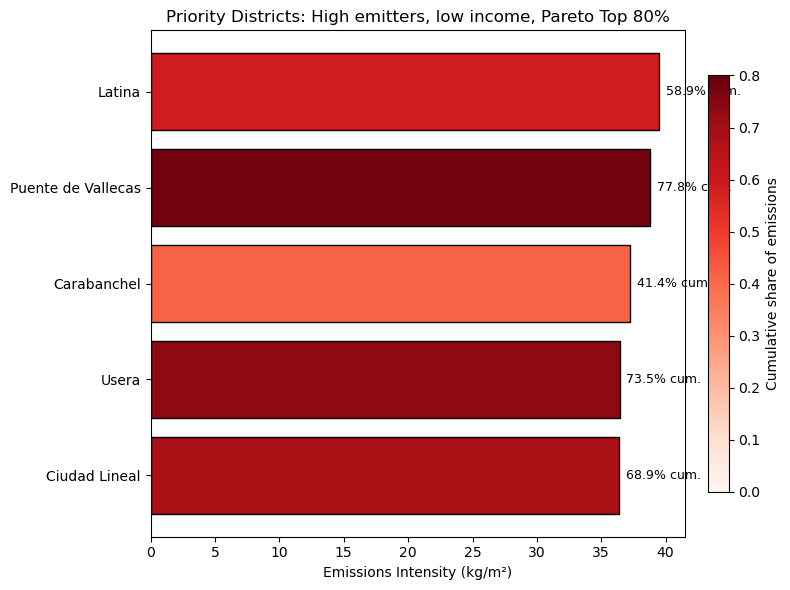

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# Copy to avoid modifying original
df = gdf.copy()

# 1. Compute median income across districts
median_income = df['avg_income'].median()

# 2. Apply selection logic: Pareto Top 20% (flag==1), avg_income < median
priority = df[(df['pareto_flag']==1) & (df['avg_income'] < median_income)].copy()

# 3. Order by intensity descending
priority = priority.sort_values('intensity_kg_m2', ascending=False)

print("Median income:", median_income)
print("Selected priority districts:\n", priority[['district_id','NOMBRE','total_co2_kg','intensity_kg_m2','avg_income','cum_share']])

# 4. Plot: bar chart showing intensity, colored by cumulative share (red scale)
cmap = mpl.cm.get_cmap("Reds")
norm = mpl.colors.Normalize(vmin=0, vmax=0.8)  # 0–80% cumulative share

fig, ax = plt.subplots(figsize=(8,6))
bars = ax.barh(priority['NOMBRE'], priority['intensity_kg_m2'],
               color=[cmap(norm(v)) for v in priority['cum_share']],
               edgecolor='k')

ax.invert_yaxis()
ax.set_xlabel("Emissions Intensity (kg/m²)")
ax.set_title("Priority Districts: High emitters, low income, Pareto Top 80%")

# Annotate each bar with cumulative share %
for bar, cs in zip(bars, priority['cum_share']):
    ax.text(bar.get_width()+0.5, bar.get_y()+bar.get_height()/2,
            f"{cs*100:.1f}% cum.", va='center', fontsize=9)

# Colorbar to show mapping of red scale to cumulative share
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm); sm._A=[]
cbar = fig.colorbar(sm, ax=ax, fraction=0.036, pad=0.04)
cbar.set_label("Cumulative share of emissions")

plt.tight_layout()
plt.show()

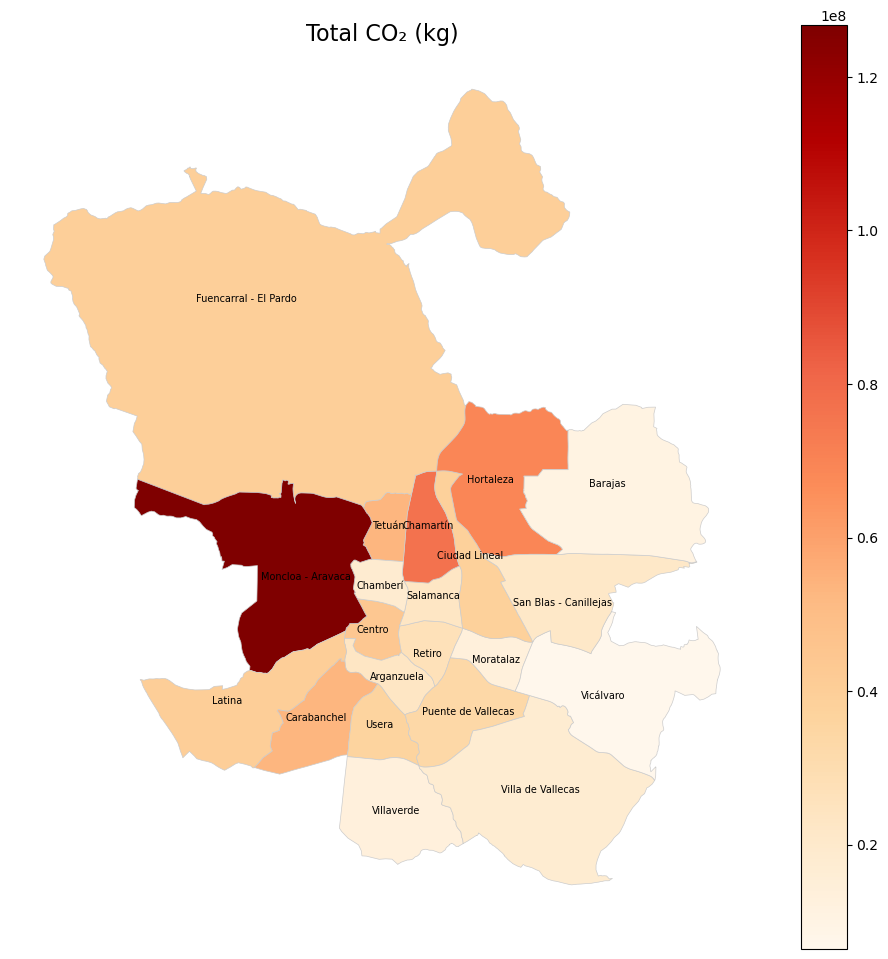

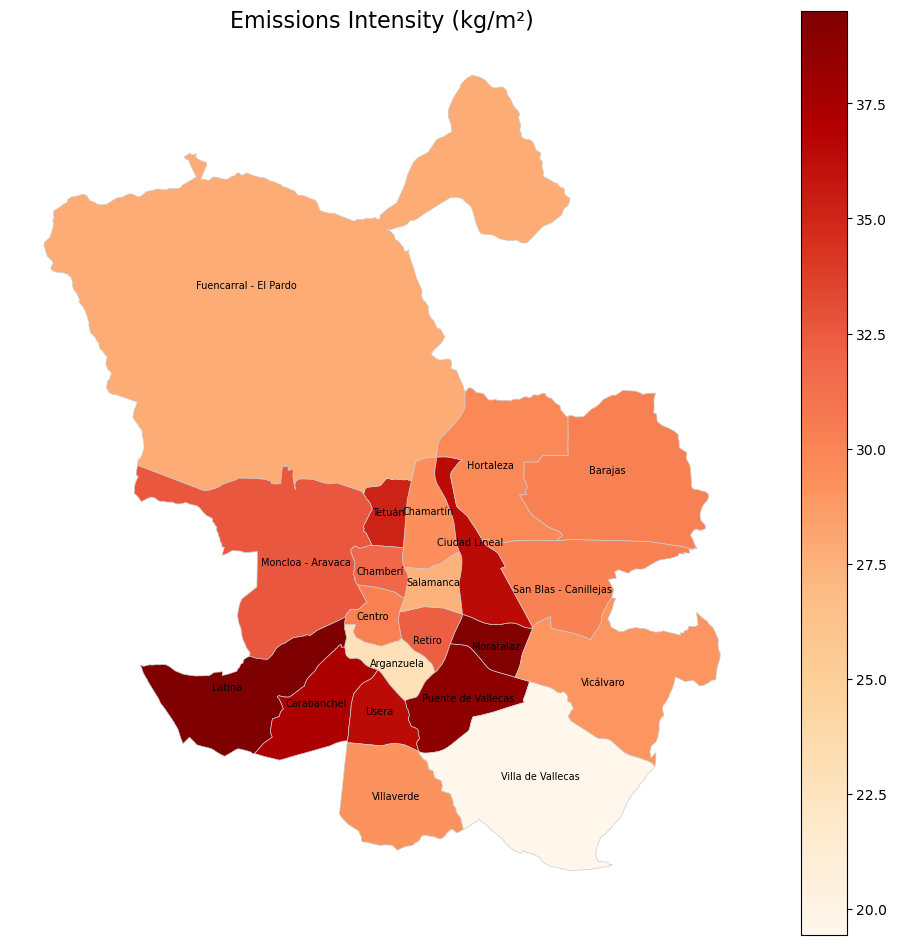

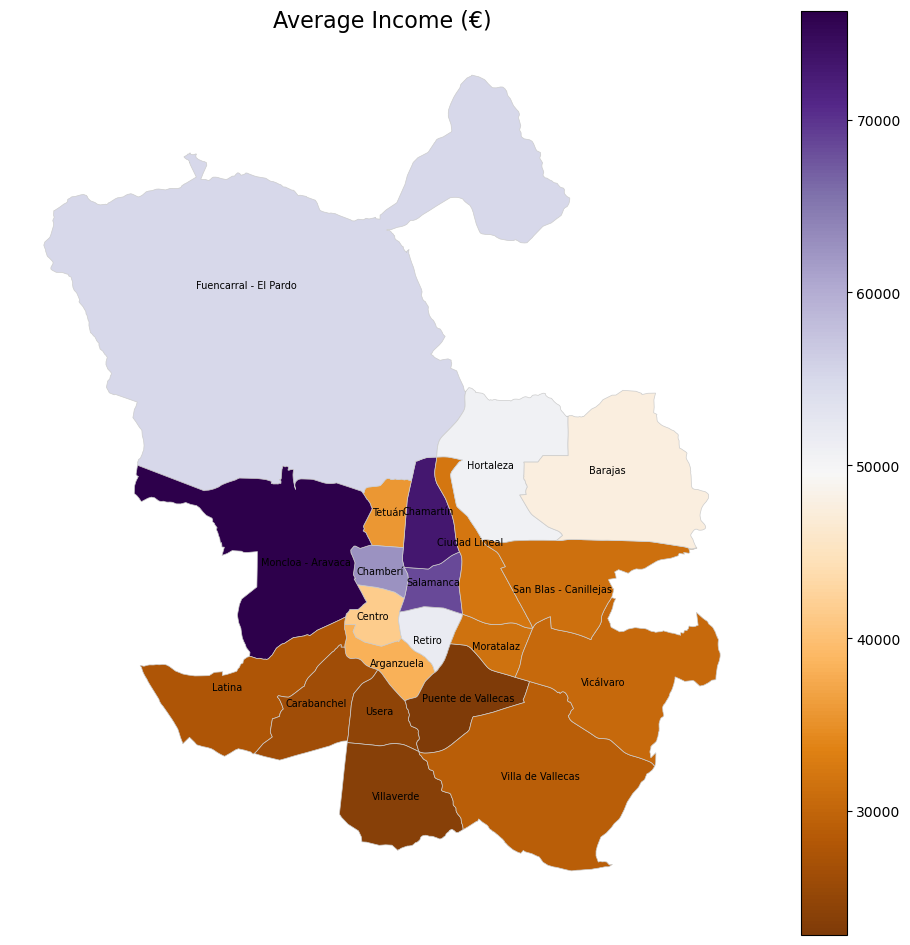

In [7]:
# Ensure centroids for labeling
gdf["centroid"] = gdf.geometry.representative_point()

def plot_map(gdf, column, title, cmap="OrRd"):
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    gdf.plot(column=column, cmap=cmap, legend=True, ax=ax,
             edgecolor="0.8", linewidth=0.5)
    
    # Add district names
    for _, row in gdf.iterrows():
        ax.text(row["centroid"].x, row["centroid"].y, row["NOMBRE"],
                ha="center", va="center", fontsize=7, color="black")
    
    ax.set_title(title, fontsize=16)
    ax.axis("off")
    plt.show()

# Plot each metric separately
plot_map(gdf, "total_co2_kg", "Total CO₂ (kg)", cmap="OrRd")
plot_map(gdf, "intensity_kg_m2", "Emissions Intensity (kg/m²)", cmap="OrRd")

# For the last map, switch to a purple–coolwarm scale
plot_map(gdf, "avg_income", "Average Income (€)", cmap="PuOr")   # or "coolwarm"

##  Why Low-Income Districts Are Prioritized  
### Por qué se priorizan los distritos de bajos ingresos

**ENGLISH**  
- Low-income households face **energy poverty**: they spend more on heating and often live in cold, inefficient homes.  
- These areas tend to have **older buildings** with poor insulation and outdated systems.  
- Public investment in these zones delivers **high impact**: better health, lower emissions, and social equity.  
- Aligns with EU and Spanish climate policies for a **just transition**.  
- Targeting high-emission, low-income districts ensures **fair and effective decarbonization**.

**ESPAÑOL**  
- Los hogares de bajos ingresos sufren **pobreza energética**: gastan más en calefacción y viven en viviendas frías e ineficientes.  
- Suelen tener **edificios antiguos**, mal aislados y con sistemas obsoletos.  
- La inversión pública en estas zonas genera **alto impacto**: mejora la salud, reduce emisiones y promueve la equidad social.  
- Está alineado con las políticas climáticas de la UE y España para una **transición justa**.  
- Priorizar distritos con **altas emisiones y bajos ingresos** garantiza una descarbonización **justa y eficaz**.

C:\Users\LAP-MPC\AppData\Local\Temp\ipykernel_8120\4031631967.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("coolwarm")


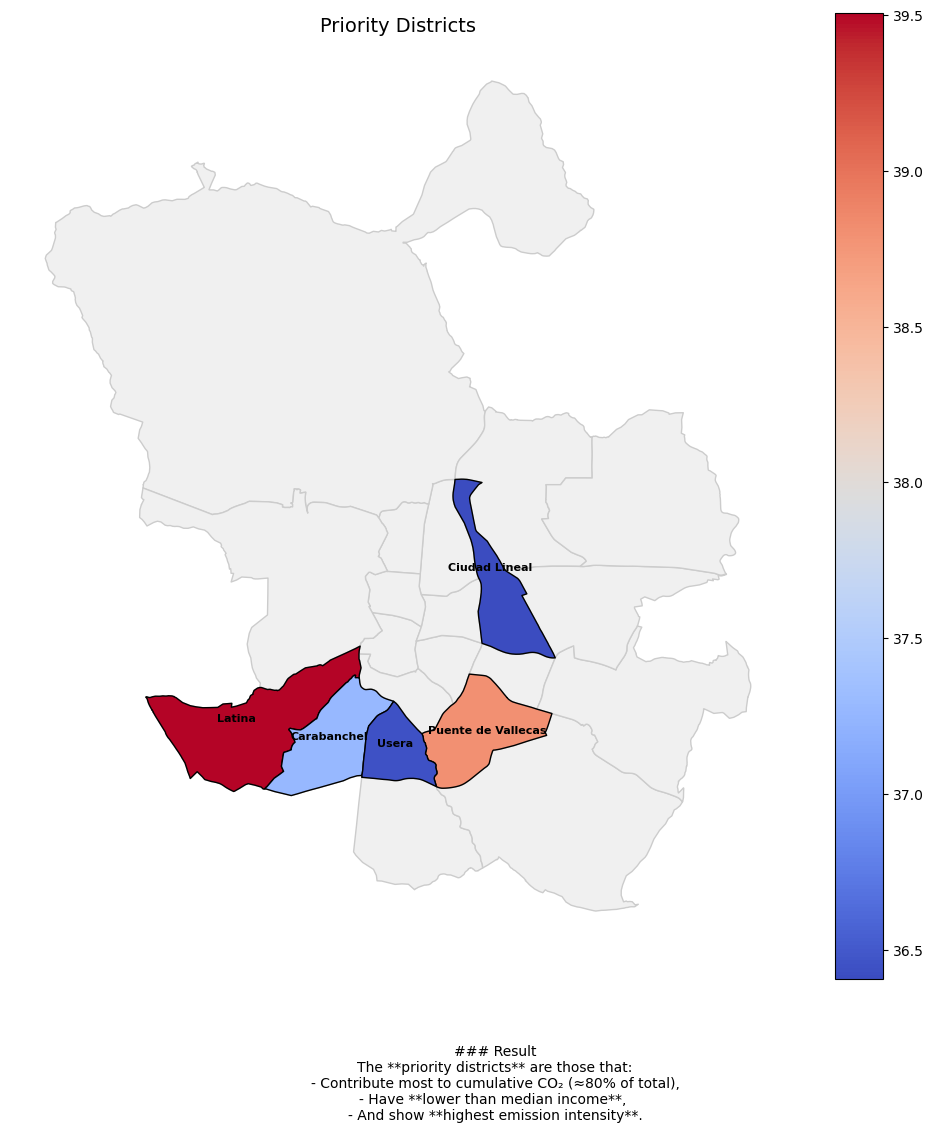

In [8]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Copy to avoid modifying original
df = gdf.copy()

# Compute median income
median_income = df['avg_income'].median()

# Select priority districts: Pareto Top 80% + below median income
priority = df[(df['pareto_flag']==1) & (df['avg_income'] < median_income)].copy()
priority = priority.sort_values('intensity_kg_m2', ascending=False)

# Representative points for labels
df['centroid'] = df.geometry.representative_point()
priority['centroid'] = priority.geometry.representative_point()

# Plot map
fig, ax = plt.subplots(1,1,figsize=(10,10))

# Base: all districts in light grey
df.plot(ax=ax, color="#f0f0f0", edgecolor="0.8")

# Priority: highlight in purple-red scale
cmap = mpl.cm.get_cmap("coolwarm")
norm = mpl.colors.Normalize(vmin=priority['intensity_kg_m2'].min(),
                            vmax=priority['intensity_kg_m2'].max())
priority.plot(ax=ax, column='intensity_kg_m2', cmap=cmap, norm=norm,
              edgecolor="black", linewidth=1.0, legend=True)

# Add district names for priority only
for _, row in priority.iterrows():
    ax.text(row['centroid'].x, row['centroid'].y, row['NOMBRE'],
            ha='center', va='center', fontsize=8, color='black', fontweight='bold')

# Title and bilingual result comments inside the figure
ax.set_title("Priority Districts", fontsize=14)
ax.axis("off")

# Add bilingual comments as text box
comment = ("### Result\n"
           "The **priority districts** are those that:\n"
           "- Contribute most to cumulative CO₂ (≈80% of total),\n"
           "- Have **lower than median income**, \n"
           "- And show **highest emission intensity**.")
plt.gcf().text(0.5, -0.05, comment, ha='center', va='top', fontsize=10)

plt.tight_layout()
plt.show()


In [13]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Shape_Leng       21 non-null     float64       
 1   Shape_Area       21 non-null     float64       
 2   COD_DIS          21 non-null     object        
 3   COD_DIS_TX       21 non-null     object        
 4   NOMBRE           21 non-null     object        
 5   DISTRI_MAY       21 non-null     object        
 6   DISTRI_MT        21 non-null     object        
 7   FCH_ALTA         0 non-null      datetime64[ms]
 8   FCH_BAJA         0 non-null      datetime64[ms]
 9   OBSERVACIO       0 non-null      object        
 10  ACUERDO          0 non-null      object        
 11  geometry         21 non-null     geometry      
 12  district_id      21 non-null     object        
 13  total_co2_kg     21 non-null     float64       
 14  intensity_kg_m2  21 non-null     flo

In [12]:
# keep only the polygon geometry
gdf = gdf.drop(columns=["centroid"])
gdf.to_file("madrid_districts.geojson", driver="GeoJSON")
